NSIDE_orig= 8192
NSIDE_new= 4096
Got RING-ordered input map


/tmp/ipykernel_1741193/2552335879.py:58: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(binmap), nest=False)


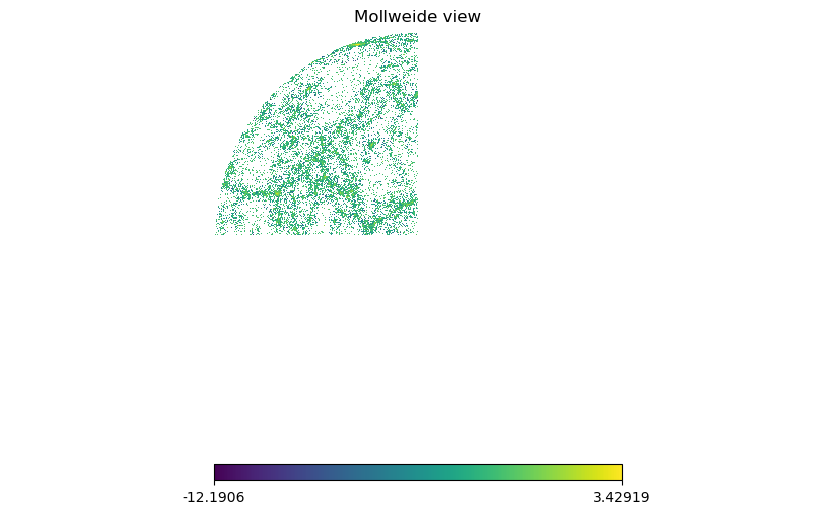

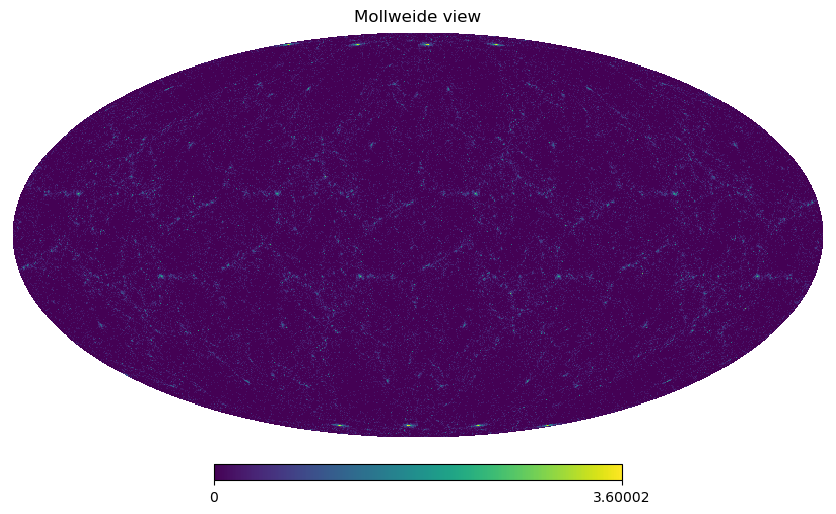

Saved
NSIDE_orig= 8192
NSIDE_new= 4096
Got RING-ordered input map


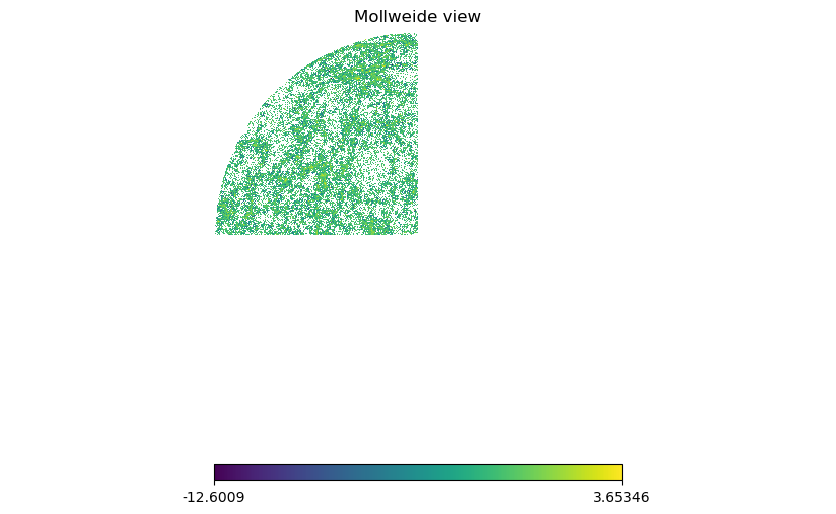

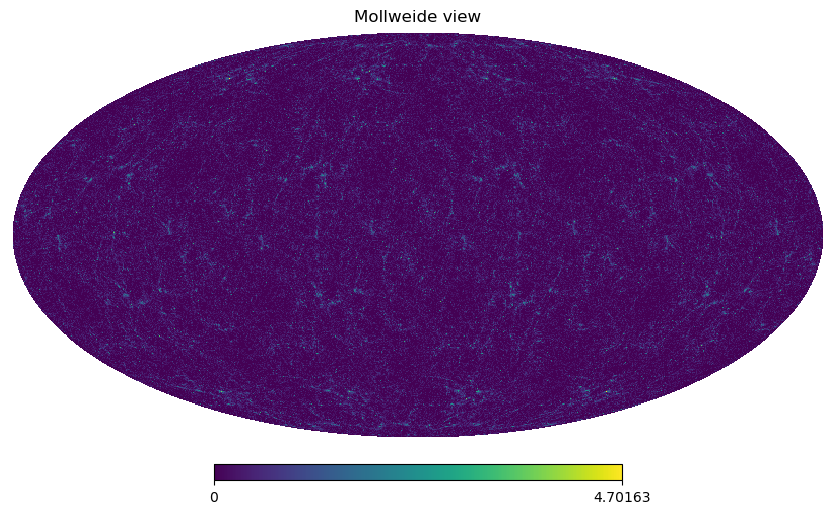

Saved
NSIDE_orig= 8192
NSIDE_new= 4096
Got RING-ordered input map


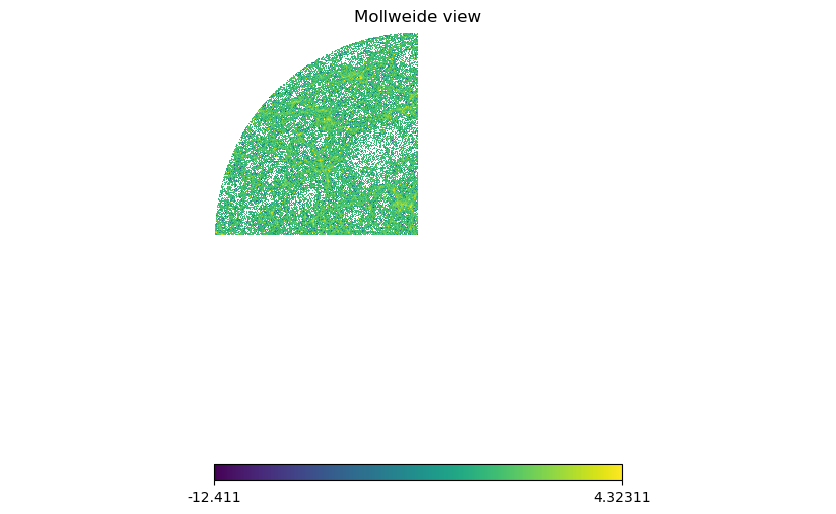

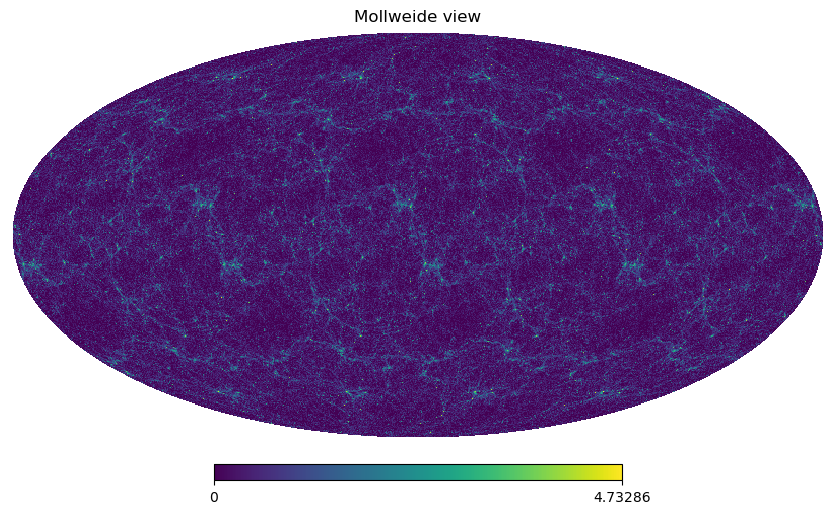

Saved
NSIDE_orig= 8192
NSIDE_new= 4096
Got RING-ordered input map


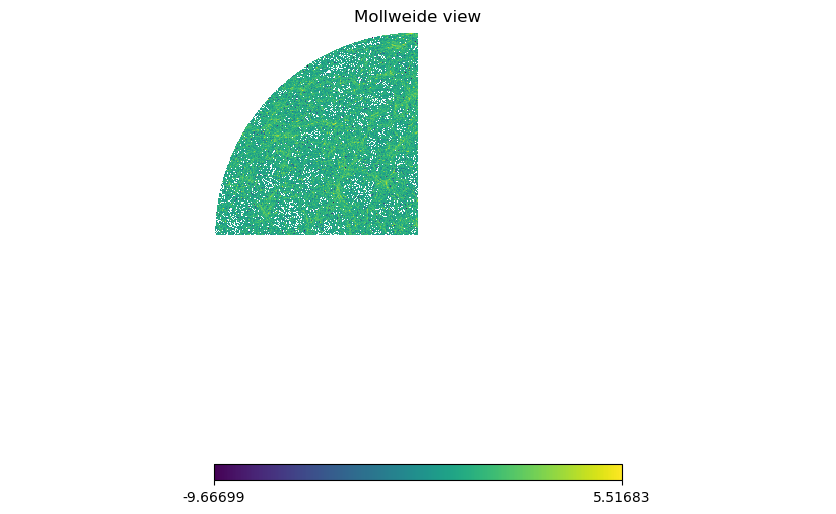

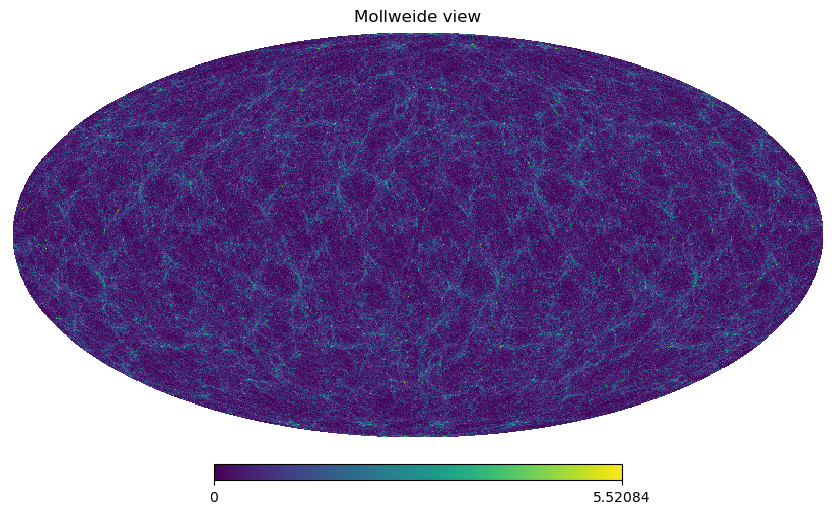

Saved
NSIDE_orig= 8192
NSIDE_new= 4096
Got RING-ordered input map


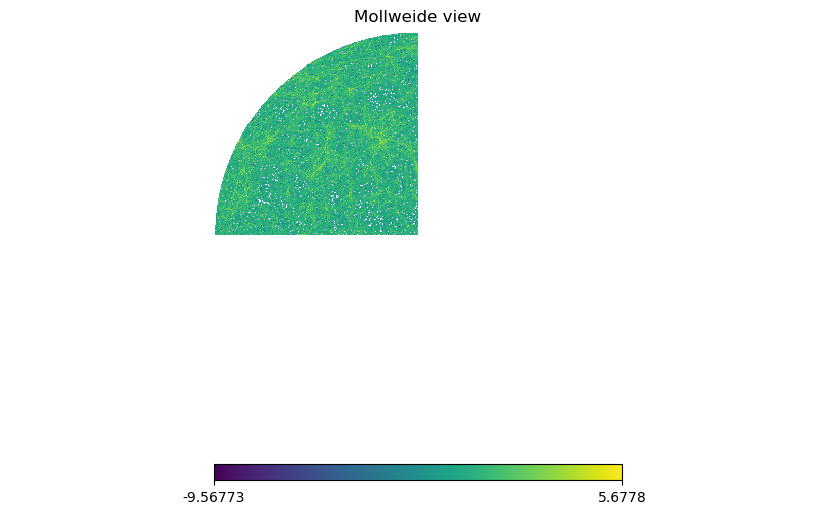

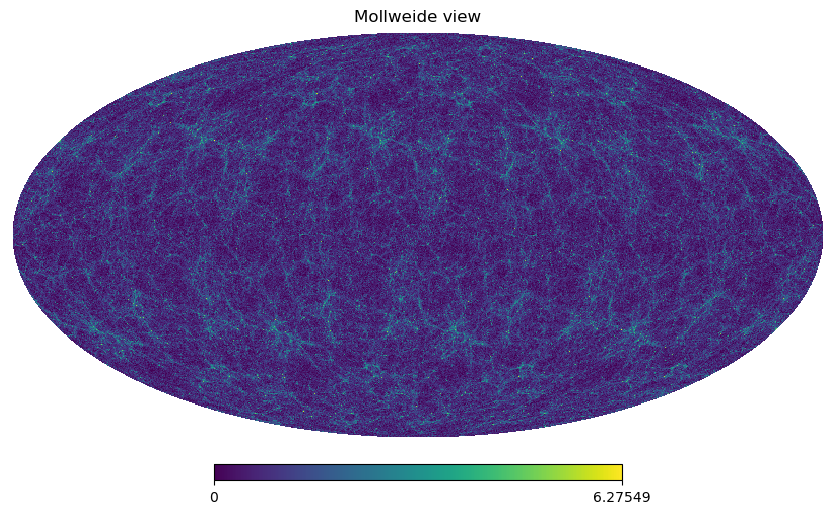

Saved
NSIDE_orig= 8192


In [ ]:
# Construct temporary all-sky mass maps so that the tidal fields 
# are not critically affected by boundary effects. Use Healpix operations instead of rotators
# For baryonified BCM

import numpy as np
import pylab as plt
import healpy as hp
import h5py

nshells=51

path = '/pscratch/sd/a/avijit97/BCM/HACC/params_dependencies/full_lightcone/Mc/2e14/nshells_'+str(nshells)+'/'
path_out = '/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/BCM/dmb_Mc2e14/fullsky_den/'

for snap in range(0,nshells):    
#for lens in range(1,nshells):
     
    lens_str = str(lens).zfill(2)
    
    filename= 'nshells_'+str(nshells)+'_imap_{}/baryonified_shells_v11.h5'.format(lens_str)

    # Load mass sheet. 
    with h5py.File(path+filename,'r') as f:
        #print('h5py file fields:',f.keys())
        nobaryon_shells = np.array(f['nobaryon_shells'])
        diff_shells = np.array(f['diff_shells'])
        #baryon_shells = nobaryon_shells+diff_shells
    
    #Uncomment for accessing dmo simulation shells, otherwise we use the baryonified shell = dmo + diff_shell 
    #if(dmo):
    #    sdens=nobaryon_shells
    #else:
    sdens=nobaryon_shells+diff_shells 

    
    
    # If format of input maps is nested, adjust the order_in='NESTED'. Output format must be ring in order to use alm2maps transforms
    # Also degrade NSIDE to 4096 as the tidal fields will be smoothed out anyway. 
    print("NSIDE_orig=", hp.get_nside(sdens[0,:]))
    binmap=hp.pixelfunc.ud_grade(sdens[0,:], 4096, pess=False, order_in='RING', order_out='RING', power=None, dtype=None)
    print("NSIDE_new=", hp.get_nside(binmap))

    # Delete full resolution maps to save memory
    del sdens diff_shells nobaryon_shells
    
    print("Got RING-ordered input map")
       
    hp.mollview(np.log(binmap), nest=False)
    plt.show()

    
    # Replicate the Octant using masked pixels:
    # Load mask for octant, and find unmasked pixel IDs

    mask = np.load('mask_allsky.npy')
    #hp.mollview(mask, nest=False)
    #plt.show()
    
    npix = hp.nside2npix(4096)
    pix_array = np.arange(npix)
    pixel_id = pix_array[mask>0]
    
    # Find angle for the good, unmasked, pixels, rotate them 7 times to populate the full sky, then extract the new pixel IDs
    # These rotations are better than reflections, which can cause additional clustering

    theta, phi = hp.pix2ang(4096, pixel_id, nest=False, lonlat=False)


    pixel_id2 = hp.ang2pix(4096, theta, phi+np.pi/2, nest=False, lonlat=False)
    pixel_id3 = hp.ang2pix(4096, theta, phi+np.pi, nest=False, lonlat=False)
    pixel_id4 = hp.ang2pix(4096, theta, phi+3*np.pi/2, nest=False, lonlat=False)
    pixel_id5 = hp.ang2pix(4096, np.pi-theta, -phi, nest=False, lonlat=False)
    pixel_id6 = hp.ang2pix(4096, np.pi-theta, -phi+np.pi/2, nest=False, lonlat=False)
    pixel_id7 = hp.ang2pix(4096, np.pi-theta, -phi+np.pi, nest=False, lonlat=False)
    pixel_id8 = hp.ang2pix(4096, np.pi-theta, -phi+3*np.pi/2, nest=False, lonlat=False)
    
    # Assign the original octant pixel values to the other 7 octant using the relation found above 

    binmap[pixel_id2]= binmap[pixel_id]
    binmap[pixel_id3]= binmap[pixel_id]
    binmap[pixel_id4]= binmap[pixel_id]
    binmap[pixel_id5]= binmap[pixel_id]
    binmap[pixel_id6]= binmap[pixel_id]
    binmap[pixel_id7]= binmap[pixel_id]
    binmap[pixel_id8]= binmap[pixel_id]

    hp.mollview(np.log(binmap+1), nest=False)
    plt.show()

    # save to file:
    fname = path_out+'density_map_'+str(lens_str)+'_dens_allsky.npy'
    np.save(fname, binmap)
    print("Saved")
    